In [ ]:
%%bash
rm -rf "sample_data" "images" "masks"
cp -r "/content/drive/MyDrive/imp documents/sattelite" "sattelite"              # make copy of data
mkdir 'images' 'masks'                                                          # make folders for images and masks

In [ ]:
!pip install git+https://github.com/tensorflow/examples

  Cloning https://github.com/tensorflow/examples to /tmp/pip-req-build-xj24kjon
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples /tmp/pip-req-build-xj24kjon
  Resolved https://github.com/tensorflow/examples to commit a55d94841a9cbf7b3b77d35bf81189fc6010dcc5
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1688024567.944070384060361013435054447535562198627925417157-py3-none-any.whl size=301568 sha256=e7343bae373bd56c4b3daa983d0da230509893415426746e659dd2043d30321e
  Stored in directory: /tmp/pip-ephem-wheel-cache-mfob3fkg/wheels/ed/fc/ac/2d5d19b0e12b4fcb0dc3f5caec90307da59414907f514e973a
Successfully built tensorflow-examples


In [ ]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf                                                         # load tensorflow
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix


In [ ]:
parent_directory='sattelite/DubaiDataset'                                       # train directory
for index,subfolder in  enumerate(os.listdir(parent_directory)):                # get folder from main directory
  if os.path.isdir(os.path.join(parent_directory,subfolder)):                   # if not a folder
    for folder in os.listdir(os.path.join(parent_directory,subfolder)):          # get folder from sub-folder
      for files in os.listdir(os.path.join(parent_directory,subfolder,folder)): # get files from folder
        files_new_name=files.split('.')[0]+f'_tile_{index}.'+files.split('.')[-1]
        os.rename(os.path.join(parent_directory,subfolder,folder,files),os.path.join(folder,files_new_name))
!rm -Rf "sattelite"                                                             # remove old directory

In [ ]:
os.path.isdir('sattelite/DubaiDataset/Tile 2')

False

In [ ]:
os.path.isdir(os.path.join(parent_directory,subfolder))

False

In [ ]:
#Load Data

images = tf.keras.utils.image_dataset_from_directory('images',labels=None,label_mode='int',class_names=None,color_mode='rgb',
                                                     batch_size=128,image_size=(256,256),shuffle=False,validation_split=0.0,
                                                     interpolation='bilinear',subset=None)

masks = tf.keras.utils.image_dataset_from_directory('masks',labels=None,label_mode='int',class_names=None,color_mode='rgb',
                                                     batch_size=128,image_size=(256,256),shuffle=False,validation_split=0.0,
                                                     interpolation='bilinear',subset=None)

Found 72 files belonging to 1 classes.
Found 72 files belonging to 1 classes.


In [ ]:
# os.path.pardir(os.path.join(parent_directory,subfolder))

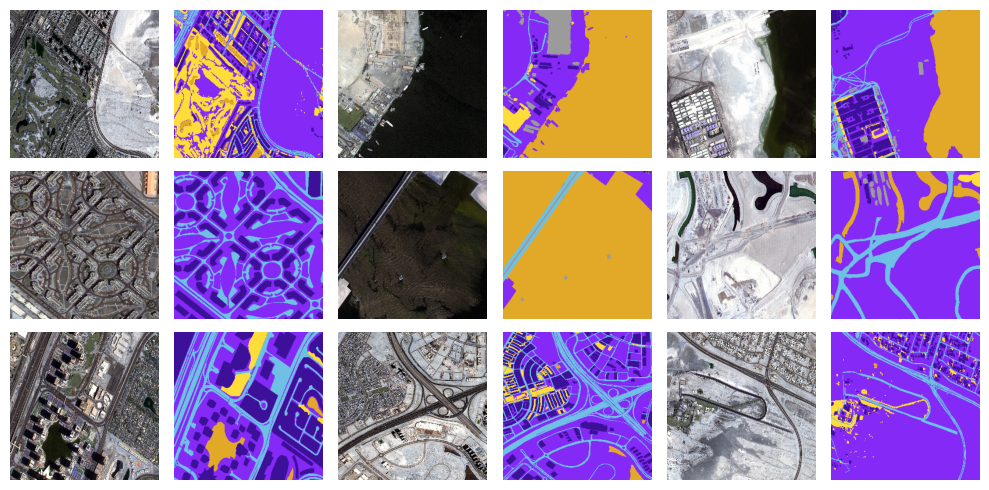

In [ ]:
for sample_images in images.take(1,name='sample_images'):break
for sample_masks in masks.take(1,name='sample_masks'):break
plot_number:int=1
plt.figure(figsize=(10,5))
for image,mask in zip(sample_images.numpy()[:9],sample_masks.numpy()[:9]):
  plt.subplot(3,6,plot_number)
  plt.imshow(image.astype('uint'),cmap='gray')
  plt.axis('off')
  plt.subplot(3,6,plot_number+1)
  plt.imshow(mask.astype('uint'),cmap='gray')
  plt.axis('off')
  plot_number+=2
plt.tight_layout()
plt.show()

In [ ]:
#see images and mask - shape and pixel ranges
print('Image batch shape:',sample_images.shape)
print('mask batch shape:',sample_masks.shape)
print('Image batch maximum value:',tf.reduce_max(sample_images),'and minimum value:',tf.reduce_min(sample_images))
print('Image batch maximum value:',tf.reduce_max(sample_images),'and minimum value:',tf.reduce_min(sample_images))
print('see pixel values (if binary mask):',set(sample_masks.numpy().flatten()))

Image batch shape: (72, 256, 256, 3)
mask batch shape: (72, 256, 256, 3)
Image batch maximum value: tf.Tensor(255.0, shape=(), dtype=float32) and minimum value: tf.Tensor(0.0, shape=(), dtype=float32)
Image batch maximum value: tf.Tensor(255.0, shape=(), dtype=float32) and minimum value: tf.Tensor(0.0, shape=(), dtype=float32)
see pixel values (if binary mask): {0.0, 1.03125, 1.0220337, 3.8671875, 3.8326263, 5.4668427, 6.2304688, 7.1640015, 6.21875, 9.796875, 9.70932, 11.105995, 10.502991, 13.145691, 14.335167, 13.306335, 16.0, 16.56696, 16.94099, 16.072956, 20.15039, 20.895878, 22.393337, 17.434803, 22.006718, 21.696392, 22.884766, 27.928272, 28.022305, 23.890034, 23.769299, 22.359959, 32.13722, 33.78593, 34.50586, 34.87369, 36.049572, 37.944523, 38.76554, 38.39933, 37.92383, 39.370647, 40.737263, 41.0, 41.62216, 40.84789, 38.72253, 45.660126, 46.194473, 40.489307, 47.18393, 49.015625, 50.618866, 52.132812, 52.645386, 52.51367, 50.280243, 54.455048, 54.524628, 57.328125, 58.0, 52.5692

In [23]:
# define downsampler -----------------------------------------------------------
# load base model - MobileNet Version 2
input_shape=(128,128,3)
base_model=tf.keras.applications.MobileNetV2(input_shape=(*input_shape[:2],3),include_top=False)

# use the activations of these layers (as outputs)
layer_names=[
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

# get model layer by its name
base_model_output_layers=[base_model.get_layer(name).output for name in layer_names]
# create the feature extraction model (downsampler / encoder)
downsampler=tf.keras.Model(inputs=base_model.input,outputs=base_model_output_layers)
# freeze model
downsampler.trainable=False
# see model summary
#downsampler.summary(line_length=140,positions= None,print_fn=None,expand_nested=False,
#                    show_trainable=False,layer_range=None)
# # make model plot
# tf.keras.utils.plot_model(downsampler,to_file='downsampler.png',show_shapes=True,show_dtype=False,
#                           show_layer_names=True,rankdir='TB',expand_nested=False,dpi=96,
#                           layer_range=None,show_layer_activations=False,show_trainable=False)

In [ ]:
len(layer_names)

5

In [ ]:
# define upsampler -------------------------------------------------------------
# the decoder/upsampler is simply a series of upsample blocks implemented

# make upsampler layers list -> pix2pix.upsample
# pix2pix.upsample -> Conv2DTranspose => Batchnorm => Dropout => Relu
#     Args:
#        filters: number of filters
#        size: filter size
#        norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
#        apply_dropout: If True, adds the dropout layer
# Returns: -> Upsample Sequential Model
upsampler_layers=[
    pix2pix.upsample(filters=512,size=3,norm_type='batchnorm',apply_dropout=False),# 4x4 -> 8x8
    pix2pix.upsample(filters=256,size=3,norm_type='batchnorm',apply_dropout=False),# 8x8 -> 16x16
    pix2pix.upsample(filters=128,size=3,norm_type='batchnorm',apply_dropout=False),# 16x16 -> 32x32
    pix2pix.upsample(filters=64,size=3,norm_type='batchnorm',apply_dropout=False), # 32x32 -> 64x64
    ]


In [ ]:
output_channels = 3


In [ ]:
# define modified U-Net model --------------------------------------------------
# paper -> https://arxiv.org/abs/1505.04597
# U-Net: Convolutional Networks for Biomedical Image Segmentation
#inputs=base_model.input#or #inputs=tf.keras.layers.Input(shape=input_shape,batch_size=None,name=None)
inputs=tf.keras.layers.Input(shape=input_shape,batch_size=None,name=None)       # single channel
uNetx=tf.keras.layers.Convolution2D(3,(3,3),strides=(1,1),padding='same')(inputs)# convert to 3 channels
uNet_downsampler_outputs=downsampler(uNetx)# 5 outputs -> KerasTensor, shapes = (None,64,64,96), (None,32,32,144), (None,16,16,192)
# (None,8,8,576), (None,4,4,320)
uNetx=uNet_downsampler_outputs[-1]# get last outputs -> < KerasTensor, shapes = (None, 4, 4, 320)
# upsampling and establishing the connections
for upsampler_layer,downsampler_layer_out in zip(upsampler_layers,uNet_downsampler_outputs[:-1][::-1]):#uNet_downsampler_outputs[:-1][::-1]
# leaving last and reversing output connections
  uNetx=upsampler_layer(uNetx)# upsample layer
  uNetx=tf.keras.layers.Concatenate()([uNetx,downsampler_layer_out])
# define output layer
outputs=tf.keras.layers.Conv2DTranspose(filters=output_channels,kernel_size=3,strides=2,padding='same',activation='sigmoid')(uNetx)# 64x64 -> 128x128
# build U-Net model
uNet=tf.keras.Model(inputs=inputs,outputs=outputs,name='custom_UNET')

# compile model
uNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-7,amsgrad=False,name='adam'),
              loss=tf.keras.losses.MeanAbsoluteError(name='mean_absolute_error'),
              metrics=['mean_squared_error'])

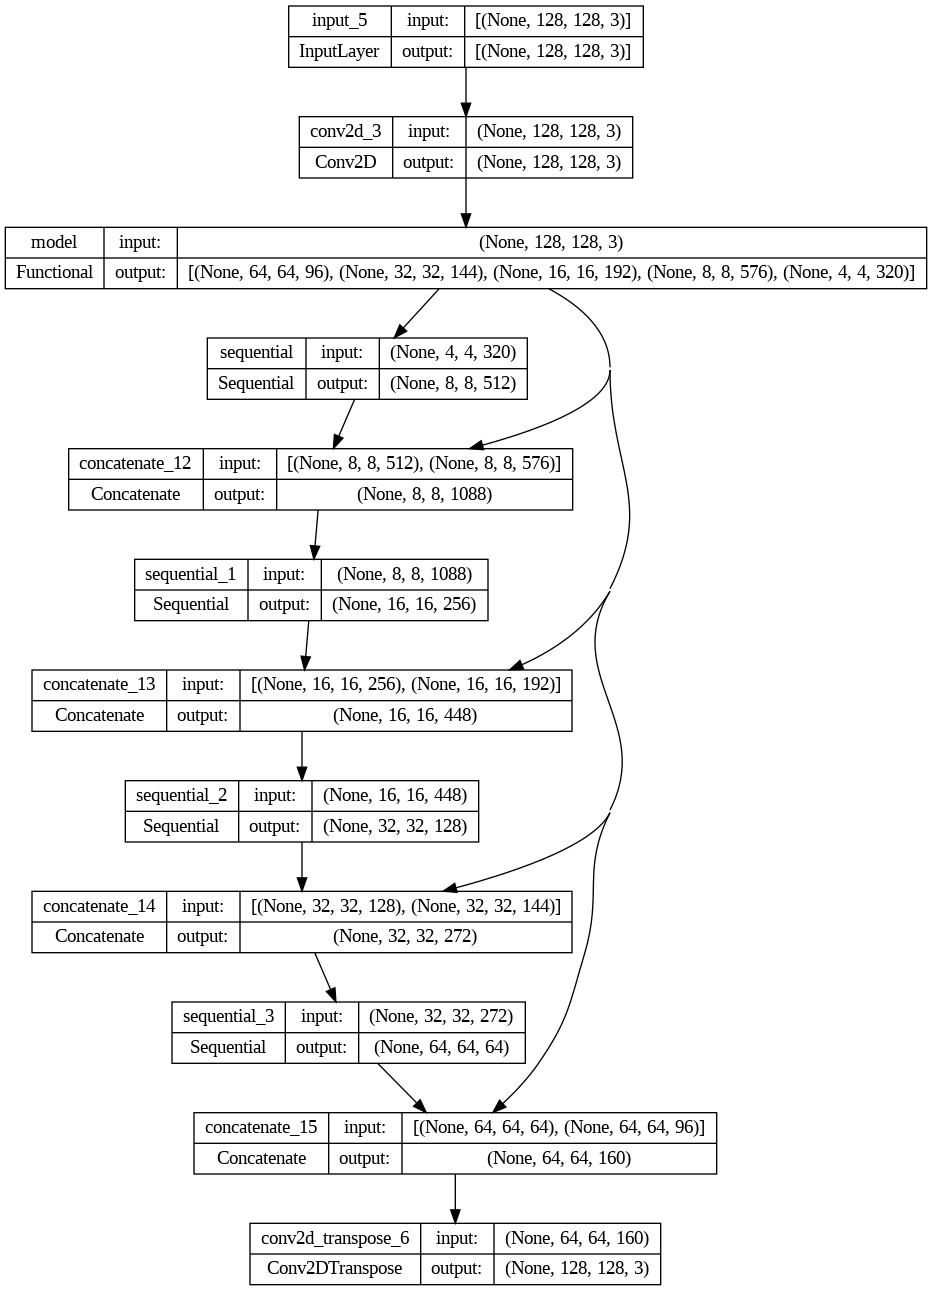

In [ ]:
# plot model -------------------------------------------------------------------
tf.keras.utils.plot_model(uNet,to_file='uNet.png',show_shapes=True,show_dtype=False,show_layer_names=True,rankdir='TB',expand_nested=False,
                          dpi=96,layer_range=None,show_layer_activations=False,show_trainable=False)

In [ ]:
 # early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=1,
                                                mode='auto',baseline=None,restore_best_weights=True,start_from_epoch=0)
# make model train
history=uNet.fit(train_ds,batch_size=None,epochs=100,verbose=2,callbacks=[early_stopping],validation_split=0,validation_data=valid_ds,
                 shuffle=True,class_weight=None,sample_weight=None,initial_epoch=0,steps_per_epoch=None,validation_steps=None,
                 validation_batch_size=None,validation_freq=1,max_queue_size=10,workers=1,use_multiprocessing=False)

NameError: ignored